In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [15]:
# Load the train, validation, and test datasets
train_data = pd.read_csv('../date/train_data.csv')
val_data = pd.read_csv('../date/val_data.csv')
test_data = pd.read_csv('../date/test_data.csv')


In [16]:
# Preprocessing
label_encoder = LabelEncoder()
train_data['Origin/Ethnicity'] = label_encoder.fit_transform(train_data['Origin/Ethnicity'])
val_data['Origin/Ethnicity'] = label_encoder.transform(val_data['Origin/Ethnicity'])
test_data['Origin/Ethnicity'] = label_encoder.transform(test_data['Origin/Ethnicity'])
train_data['Genre'] = label_encoder.fit_transform(train_data['Genre'])
val_data['Genre'] = label_encoder.transform(val_data['Genre'])
test_data['Genre'] = label_encoder.transform(test_data['Genre'])

In [17]:
# TF-IDF for 'Plot' column
tfidf_vectorizer = TfidfVectorizer(max_features=100)
train_plot_tfidf = tfidf_vectorizer.fit_transform(train_data['Plot'].fillna(''))
val_plot_tfidf = tfidf_vectorizer.transform(val_data['Plot'].fillna(''))
test_plot_tfidf = tfidf_vectorizer.transform(test_data['Plot'].fillna(''))

# Word2Vec for 'Plot' column
tokenized_plots_train = train_data['Plot'].fillna('').apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=tokenized_plots_train, vector_size=80, window=5, min_count=1, workers=4)

In [18]:
def get_plot_embedding(plot):
    embeddings = [word2vec_model.wv[word] for word in plot if word in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

train_plot_word2vec = np.vstack(train_data['Plot'].fillna('').apply(lambda x: get_plot_embedding(x.split())).values)
val_plot_word2vec = np.vstack(val_data['Plot'].fillna('').apply(lambda x: get_plot_embedding(x.split())).values)
test_plot_word2vec = np.vstack(test_data['Plot'].fillna('').apply(lambda x: get_plot_embedding(x.split())).values)


In [19]:
# Combine features for 'Plot'
train_combined_text_features = np.hstack((train_plot_word2vec, train_plot_tfidf.toarray()))
val_combined_text_features = np.hstack((val_plot_word2vec, val_plot_tfidf.toarray()))
test_combined_text_features = np.hstack((test_plot_word2vec, test_plot_tfidf.toarray()))

# Combine numeric and textual features
scaler = StandardScaler()
train_numeric_features = scaler.fit_transform(train_data[['Release Year', 'Origin/Ethnicity']])
val_numeric_features = scaler.transform(val_data[['Release Year', 'Origin/Ethnicity']])
test_numeric_features = scaler.transform(test_data[['Release Year', 'Origin/Ethnicity']])

X_train = np.hstack((train_numeric_features, train_combined_text_features))
X_val = np.hstack((val_numeric_features, val_combined_text_features))
X_test = np.hstack((test_numeric_features, test_combined_text_features))

y_train = train_data['Genre']
y_val = val_data['Genre']
y_test = test_data['Genre']

In [20]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [21]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [22]:
# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)


In [23]:
# Perform grid search with the SMOTE-resampled data
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 300]},
             scoring='accuracy', verbose=1)

In [24]:
# Best parameters and score
print("Best Parameters from Grid Search:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

Best Parameters from Grid Search: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation Accuracy: 0.82


In [25]:
# Evaluate on validation set
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Evaluate on test set
y_test_pred = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Validation Accuracy: 0.53
Test Accuracy: 0.52


In [26]:
# Classification report
print("\nClassification Report for Test Data:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Classification Report for Test Data:
              precision    recall  f1-score   support

      action       0.44      0.39      0.41       108
      comedy       0.56      0.44      0.49       450
       drama       0.53      0.65      0.58       578
      horror       0.59      0.56      0.58       112
     romance       0.43      0.44      0.44       100
    thriller       0.28      0.20      0.23        80

    accuracy                           0.52      1428
   macro avg       0.47      0.45      0.45      1428
weighted avg       0.51      0.52      0.51      1428



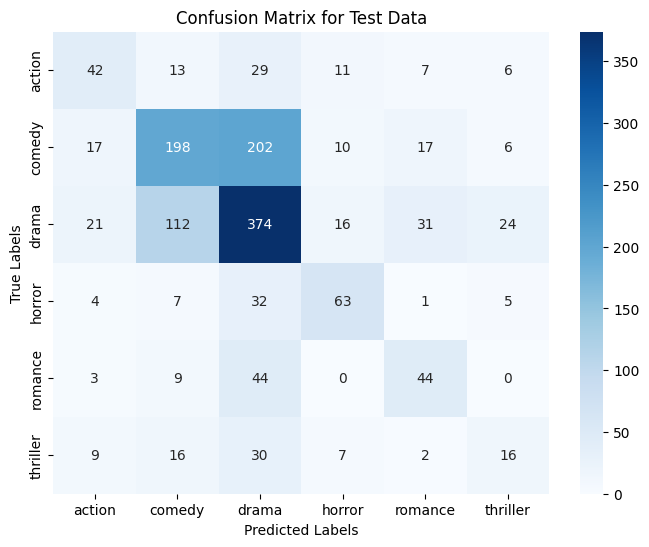

In [27]:


# Confusion Matrix for Test Data
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

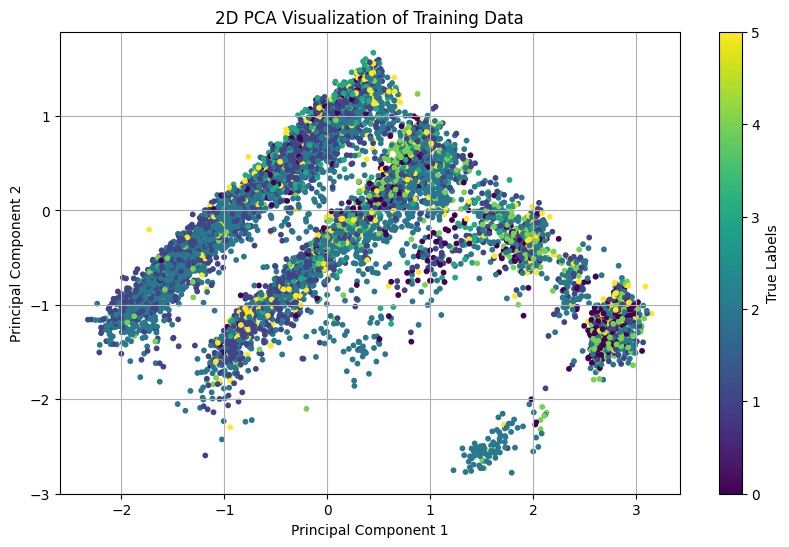

In [28]:

# PCA Visualization of Train Data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=y_train,
    cmap='viridis',
    s=10
)
plt.colorbar(scatter, label="True Labels")
plt.title("2D PCA Visualization of Training Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
